In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import LeaveOneOut
import copy
warnings.filterwarnings('ignore')

#%matplotlib inline
%matplotlib widget
#%matplotlib qt

# Class

In [218]:
class Knn:
    
    def __init__(self, n_neighbors = 1, use_KDTree = False):
        self.n_neighbours= n_neighbors
        
    def fit(self,X,y):
        self.X=X
        self.y=np.array([y]).T
    
    def predict_one(self,X):
        data=np.hstack([self.X,self.y])
        df=pd.DataFrame(data,columns=[i for i in range(data.shape[1]-1)]+['class'])
        df['distance']=np.sqrt(np.sum(np.power(self.X-X,2),axis=1))
        df.sort_values(by='distance',inplace=True)
        final_class=df.head(self.n_neighbours)['class'].value_counts().index[0]
        return final_class
        
    def predict(self,X):
        arr=np.zeros(X.shape[0])
        
        for i in range(len(arr)):
            arr[i]=self.predict_one(X[i,:])
            
        return arr
    
    def predict_regression_one(self,X):
        
        data=np.hstack([self.X,self.y])
        df=pd.DataFrame(data,columns=[i for i in range(data.shape[1]-1)]+['y'])
        df['distance']=np.sqrt(np.sum(np.power(self.X-X,2),axis=1))
        df.sort_values(by='distance',inplace=True)
        final_class=df.head(self.n_neighbours)['y'].mean()
        return final_class
    
    def predict_regression(self,X):
        arr=np.zeros(X.shape[0])
        
        for i in range(len(arr)):
            arr[i]=self.predict_regression_one(X[i,:])
            
        return arr
    
    def score_loo(self,start=1,stop=50,step=5):
        knn=copy.copy(self)
        
        loo = LeaveOneOut()
        loo.get_n_splits(X)

        results=pd.DataFrame(columns=['n_neighbours','success'])

        for n_neighbours in np.arange(start,stop,step):

            success=0
            knn.n_neighbours=n_neighbours
            for train_index, test_index in loo.split(X):
                
                X_train=X[train_index]
                X_test=X[test_index]
                y_train=y[train_index]
                y_test=y[test_index]
                
                knn.fit(X_train,y_train)
                
                pred=knn.predict_one(X_test)
                if pred==y_test:
                    success+=1
                    
            row=pd.Series({'n_neighbours':knn.n_neighbours,'success':success/loo.get_n_splits(X)})
            results=results.append(row,ignore_index=True)
        results['success']=results['success']*100
        return results
    
    def score_regression_loo(self,start,stop,step):
        knn=copy.copy(self)
        
        loo = LeaveOneOut()
        loo.get_n_splits(X)

        results=pd.DataFrame(columns=['n_neighbours','MAE'])

        for n_neighbours in np.arange(start,stop,step):

            error=0
            knn.n_neighbours=n_neighbours
            for train_index, test_index in loo.split(X):
                
                X_train=X[train_index]
                X_test=X[test_index]
                y_train=y[train_index]
                y_test=y[test_index]
                
                knn.fit(X_train,y_train)
                
                pred=knn.predict_regression_one(X_test)
                error+=np.abs(pred-y_test[0])
                
            row=pd.Series({'n_neighbours':knn.n_neighbours,'MAE':error/loo.get_n_splits(X)})
            results=results.append(row,ignore_index=True)
        return results

# Random Data

In [219]:
X,y = datasets.make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=3,
)

knn=Knn(n_neighbors=1)
knn.fit(X,y)

n_points=100
mesh=np.meshgrid(np.linspace(min(X[:,0]),max(X[:,0]),n_points) , np.linspace(min(X[:,1]),max(X[:,1]),n_points))
data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T

predicted=knn.predict(data).reshape(n_points,n_points)

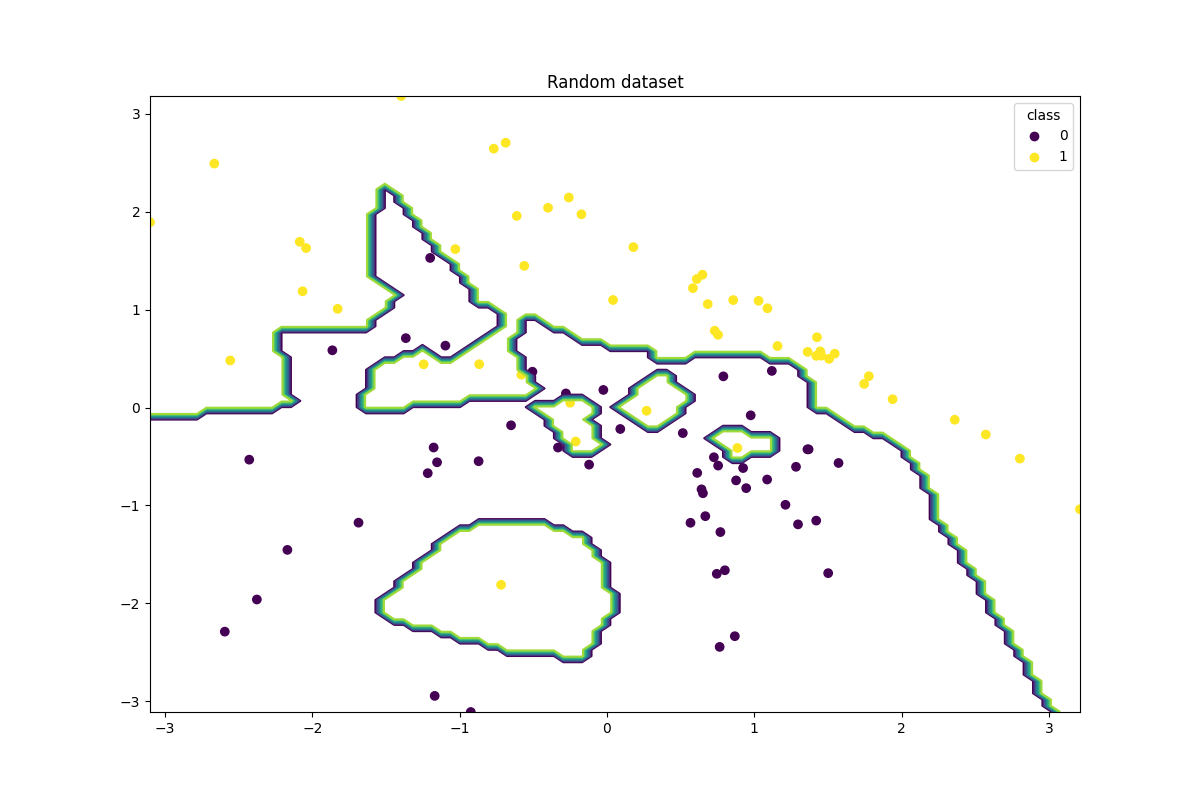

In [220]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
plt.title('Random dataset')

#scat2=ax.scatter(mesh[0],mesh[1],c=predicted,s=1)
#plt.legend(handles=scat2.legend_elements()[0], labels=list(range(len(np.unique(y)))), title="class")
ax.contour(mesh[0],mesh[1],predicted)

scat=ax.scatter(X[:,0],X[:,1],c=y)

plt.legend(handles=scat.legend_elements()[0], labels=list(range(len(np.unique(y)))), title="class")

plt.show()

# Random data LOO Cross validation

In [221]:
res=knn.score_loo(1,50,1)
res.sort_values(by=['success','n_neighbours'],ascending=[False,True]).head(5)

,n_neighbours,success
10,11.0,86.0
18,19.0,86.0
20,21.0,86.0
21,22.0,86.0
22,23.0,86.0


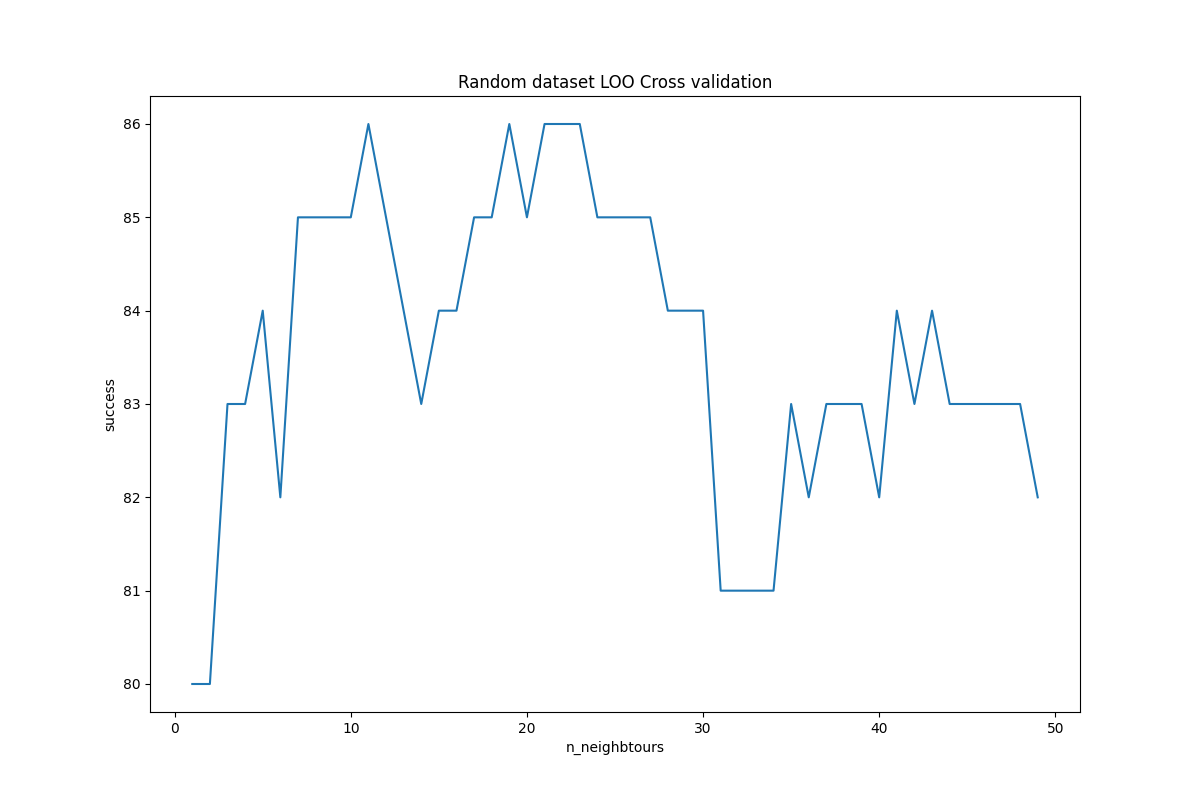

In [222]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax.set_title('Random dataset LOO Cross validation')
ax.set_xlabel('n_neighbtours')
ax.set_ylabel('success')
ax.plot(res['n_neighbours'],res['success'])
plt.show()

# Iris

In [223]:
iris = datasets.load_iris()
X=iris.data
y=iris.target

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

knn=Knn(n_neighbors=1)
knn.fit(X,y)

n_points=100
mesh=np.meshgrid(np.linspace(min(X_r[:,0]),max(X_r[:,0]),n_points) , np.linspace(min(X_r[:,1]),max(X_r[:,1]),n_points))
data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T

data_r=pca.inverse_transform(data)
predicted=knn.predict(data_r).reshape(n_points,n_points)


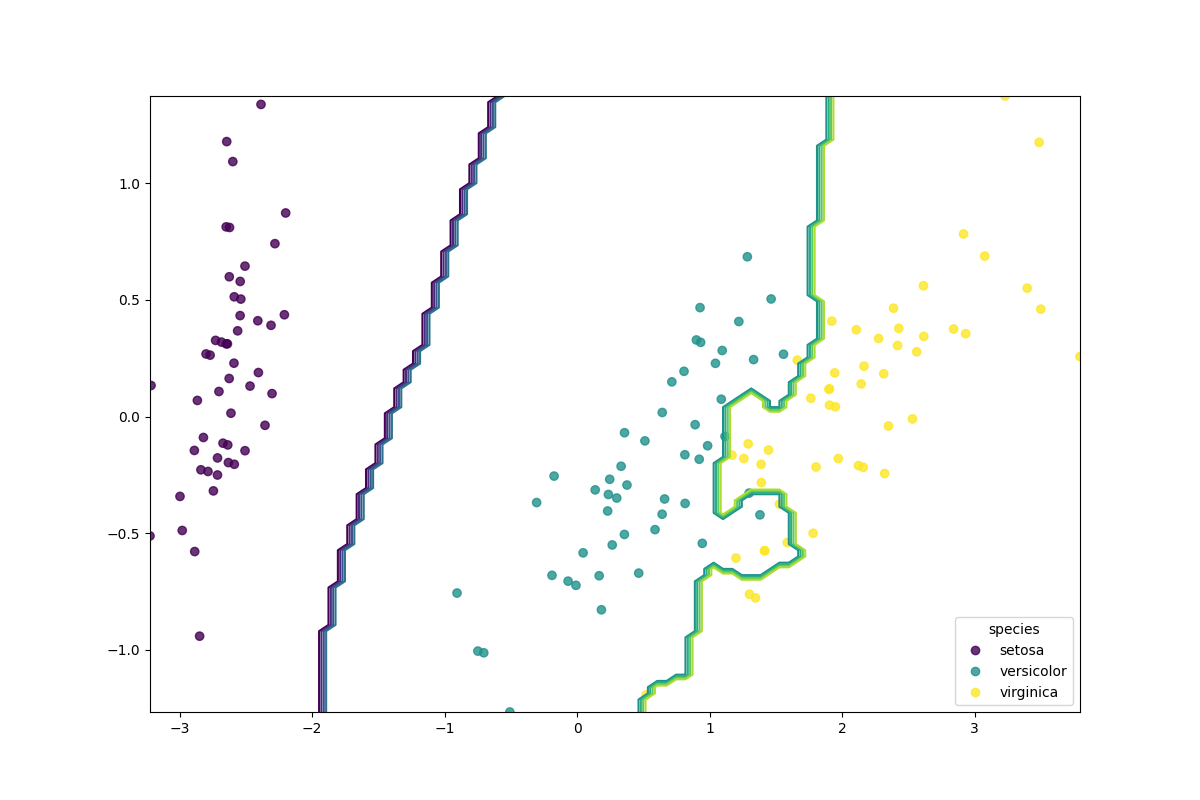

In [224]:
fig,ax=plt.subplots(1,1,figsize=(12,8))

ax.contour(mesh[0],mesh[1],predicted)

scat=plt.scatter(X_r[:,0],X_r[:,1],c=y,alpha=0.8)
ax.legend(handles=scat.legend_elements()[0], labels=iris.target_names.tolist(), title="species")
plt.show()

# Iris LOO Cross validation

In [225]:
res=knn.score_loo(1,50,1)
res.sort_values(by=['success','n_neighbours'],ascending=[False,True]).head(5)

,n_neighbours,success
18,19.0,98.000000
20,21.0,98.000000
10,11.0,97.333333
13,14.0,97.333333
14,15.0,97.333333


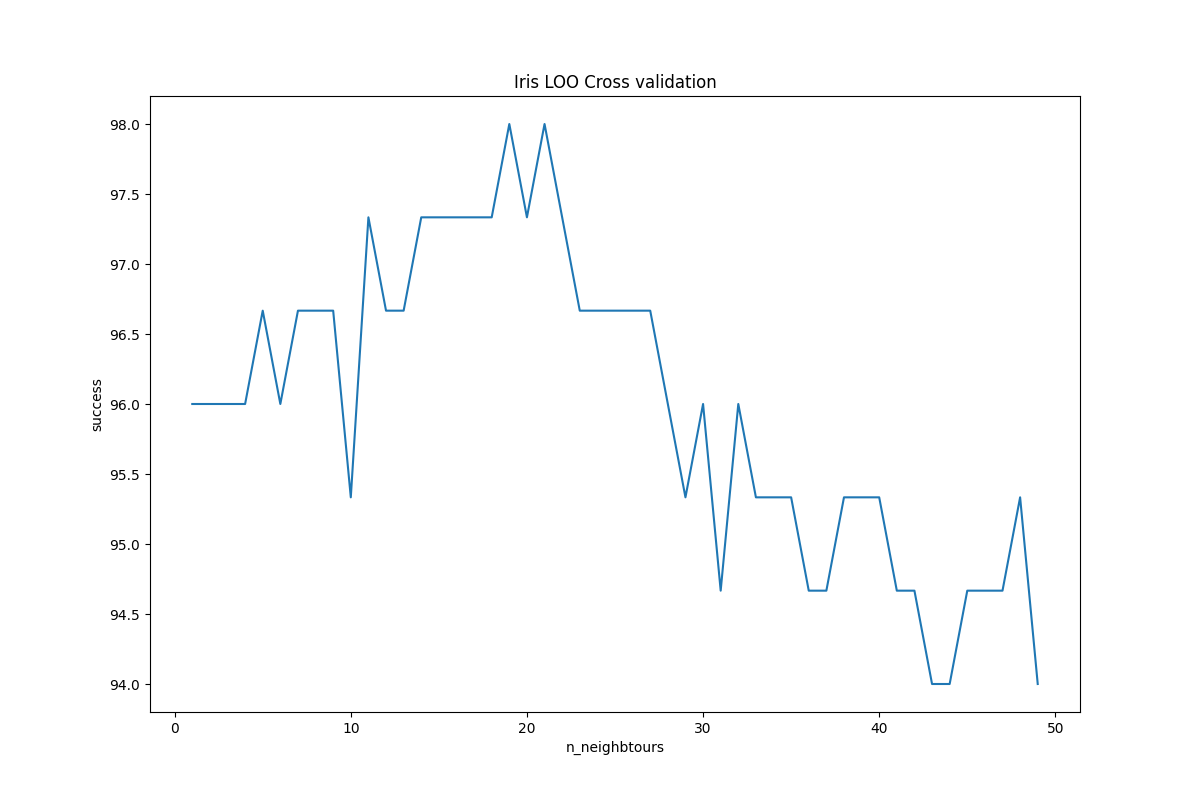

In [226]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax.set_title('Iris LOO Cross validation')
ax.set_xlabel('n_neighbtours')
ax.set_ylabel('success')
ax.plot(res['n_neighbours'],res['success'])
plt.show()

# Regression

In [227]:
X,y=datasets.make_regression(
    n_samples=100,
    n_features=1,
    random_state=0,
    noise=30
)

n_points=1000
data=np.vstack(np.linspace(min(X),max(X),n_points))

knn=Knn(n_neighbors=7)
knn.fit(X,y)

predicted=knn.predict_regression(data)

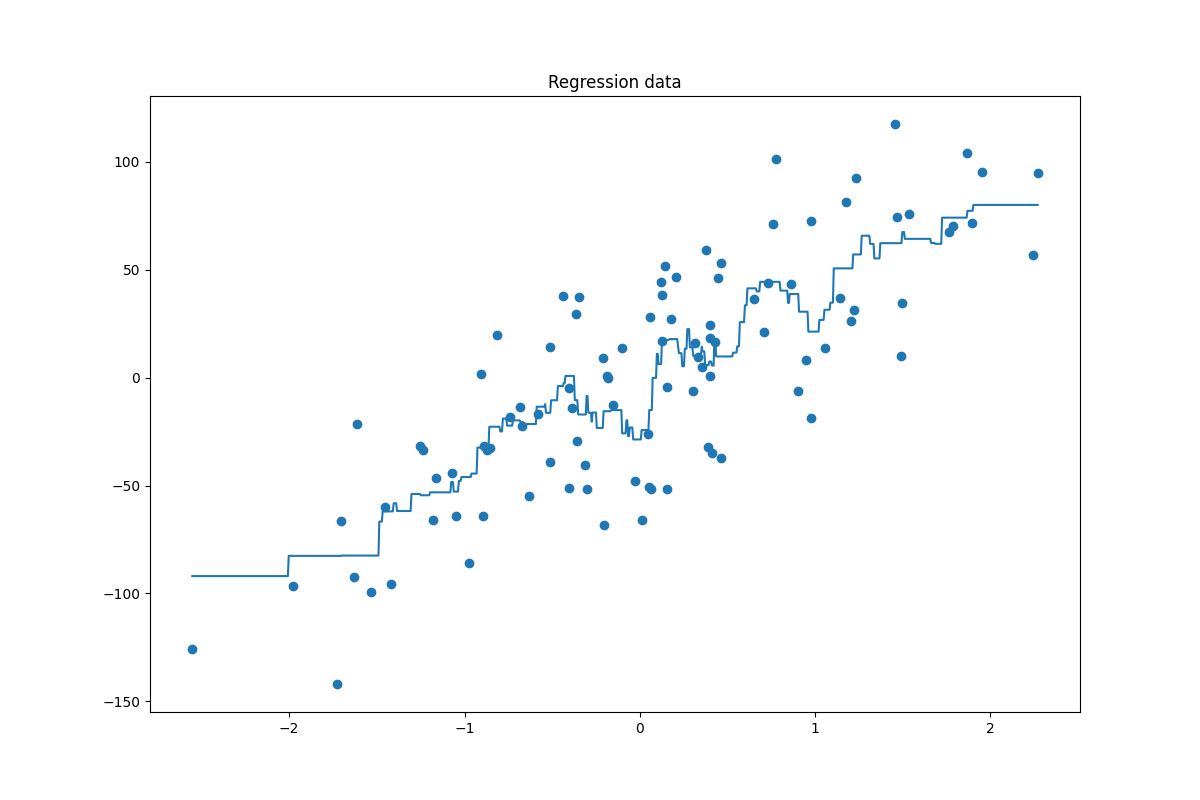

   n_neighbours        MAE
0           7.0  28.363918


In [228]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
plt.title('Regression data')

#scat2=ax.scatter(mesh[0],mesh[1],s=1)
ax.plot(data,predicted)
scat=ax.scatter(X,y)

plt.show()
print(knn.score_regression_loo(knn.n_neighbours,knn.n_neighbours+1,1))

# Regression LOO cross validation

In [229]:
res=knn.score_regression_loo(1,100,1)
res.sort_values(by=['MAE','n_neighbours'],ascending=[True,False]).head(5)

,n_neighbours,MAE
6,7.0,28.363918
10,11.0,28.447997
9,10.0,28.519753
5,6.0,28.557446
17,18.0,28.699620


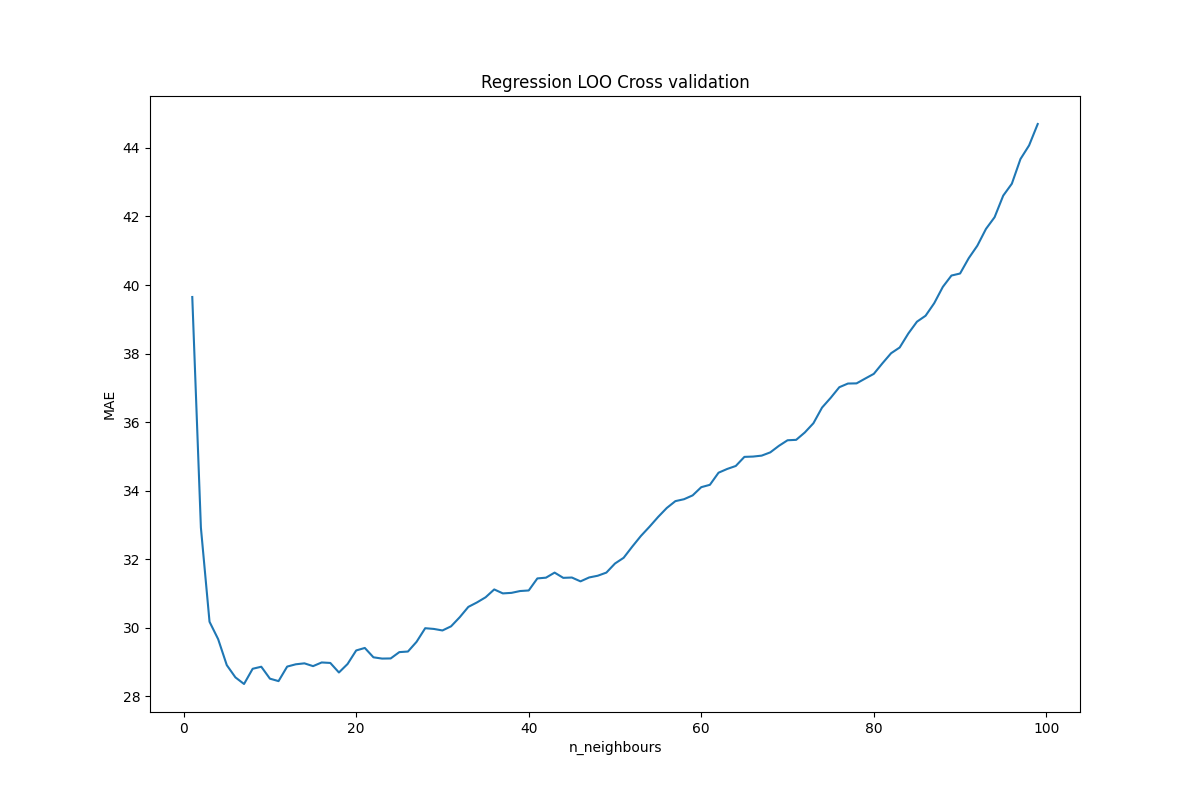

In [230]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax.set_title('Regression LOO Cross validation')
ax.set_xlabel('n_neighbours')
ax.set_ylabel('MAE')
ax.plot(res['n_neighbours'],res['MAE'])
plt.show()

# Regression 3d

In [231]:
X,y=datasets.make_regression(
    n_samples=100,
    n_features=2,
    random_state=0,
    noise=30
)

knn=Knn(n_neighbors=7)
knn.fit(X,y)

n_points=100
mesh=np.meshgrid(np.linspace(min(X[:,0]),max(X[:,0]),n_points) , np.linspace(min(X[:,1]),max(X[:,1]),n_points))
data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T

predicted=knn.predict_regression(data).reshape(n_points,n_points)

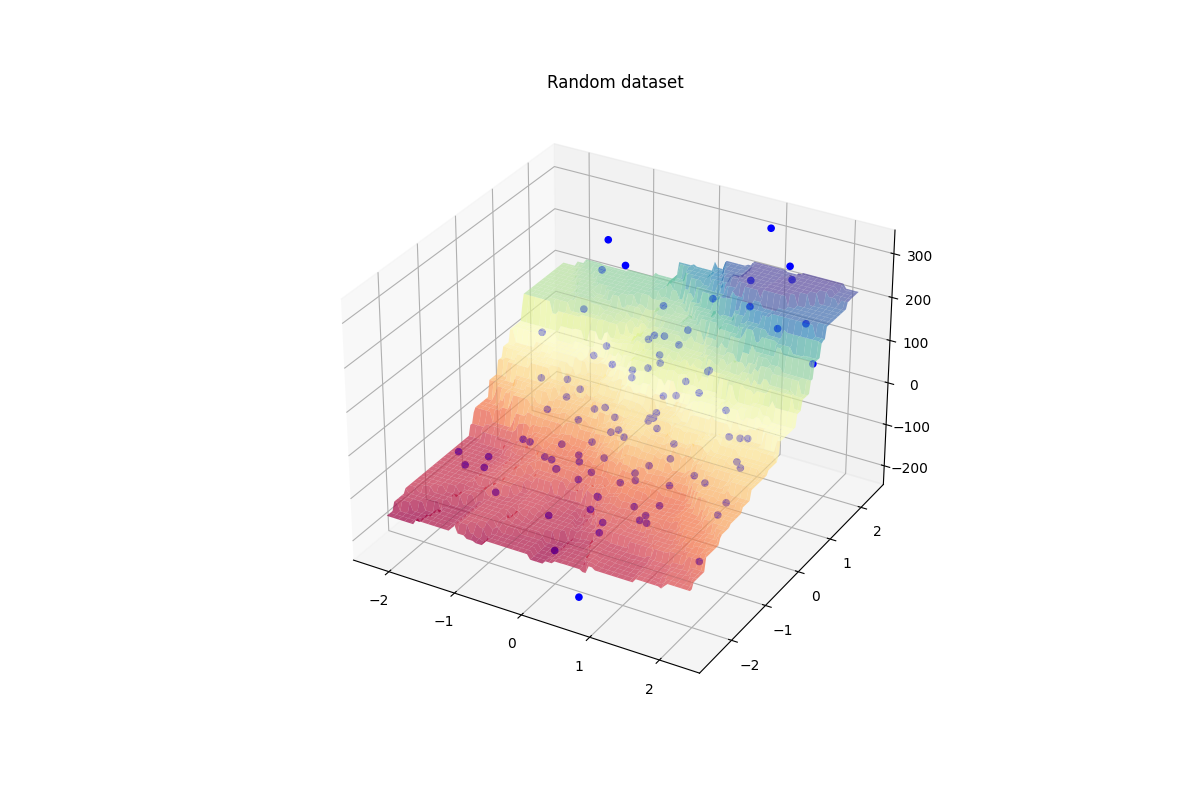

In [232]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(projection='3d')

plt.title('Random dataset')



#scat=ax.scatter3D(data[:,0],data[:,1],predicted,s=1,c='red')
surf=ax.plot_surface(data[:,0].reshape(n_points,n_points),data[:,1].reshape(n_points,n_points),predicted,cmap=plt.cm.Spectral,alpha=0.7)

scat=ax.scatter3D(X[:,0],X[:,1],y,s=20,c='blue',alpha=1)

#ax.contour(mesh[0],mesh[1],predicted)

plt.show()

# Regression 3d LOO cross validation

In [233]:
res=knn.score_regression_loo(1,100,1)
res.sort_values(by=['MAE','n_neighbours'],ascending=[True,False]).head(5)

,n_neighbours,MAE
4,5.0,28.483978
3,4.0,28.496244
2,3.0,28.794268
1,2.0,29.449240
5,6.0,30.049633


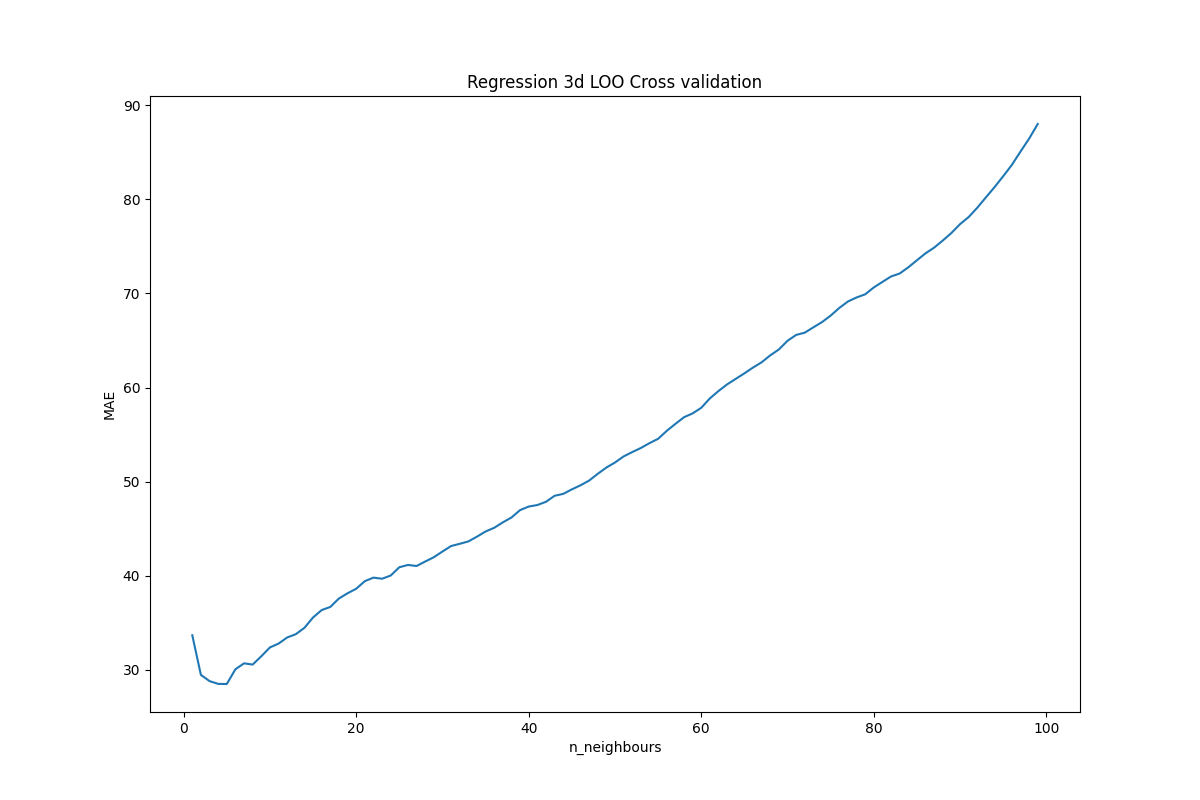

In [234]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax.set_title('Regression 3d LOO Cross validation')
ax.set_xlabel('n_neighbours')
ax.set_ylabel('MAE')
ax.plot(res['n_neighbours'],res['MAE'])
plt.show()